In [2]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
@colaborators: Thiago Russo, Emmanuel Perotto
"""


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from preprocessing import generate_freq_dist_plot, generate_wordcloud

## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [3]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "feeds_label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and start to treat the it's structure
We'll have a first look at the raw data and after analysing it's structure we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [4]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.info())
print()
print(df_ribon_news['Label_Train'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB
None

['Animais' 'Solidariedade' 'Familia' 'Criancas' 'Proposito' 'Diversidade'
 'Educacao' 'Ecologia' 'Saude' 'Idosos' 'Ciencia' 'Celebracao' 'Etnias'
 'Esporte' 'Cultura' 'proposito' 'Empreendedorismo' 'empreendedorismo'
 'solidariedade' 'diversidade' 'celebracao' 'ecologia' 'etnias' 'ciencia'
 'saude' 'cultura' 'educacao' 'criancas']


### Results
Based on the previous step it's possible to notice two things:

1) First is that the column labels are not all uppercase or lowercase. 

2) The categories avaiable to classify are not all in the same case either which could lead to later confunsion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **uppercase**

2) All **target categories** will also be **uppercase**

In [5]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
print("Column names are now: ", df_ribon_news.columns.to_list())
print()
print(TARGET_VARIABLE + " categories are now: ", df_ribon_news[TARGET_VARIABLE].unique())

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']

LABEL_TRAIN categories are now:  ['ANIMAIS' 'SOLIDARIEDADE' 'FAMILIA' 'CRIANCAS' 'PROPOSITO' 'DIVERSIDADE'
 'EDUCACAO' 'ECOLOGIA' 'SAUDE' 'IDOSOS' 'CIENCIA' 'CELEBRACAO' 'ETNIAS'
 'ESPORTE' 'CULTURA' 'EMPREENDEDORISMO']


### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [6]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [7]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/ribon/feeds_label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [8]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           888 non-null    int64 
 1   PICK_COUNT   888 non-null    int64 
 2   CONTENT      886 non-null    object
 3   TITLE        888 non-null    object
 4   LABEL_TRAIN  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 41.6+ KB
None


### Choosing text data and dropping unwanted variables
Not all columns available in data will be useful for the label classification.

In [9]:
""" In the previous results, we could that are two text variables besides the target: CONTENT and TITLE.
There's also the numeric variable pick_count which is unrelated to label, so let's add it to a unwanted list """
unwanted_columns = ['PICK_COUNT']

""" As CONTENT is empty in two cases let's compare it to title which is not empty in any case """
compared_columns = ['CONTENT', 'TITLE']
columns_stats = []
columns_series = []
for column in compared_columns:
    column_series = df_ribon_news_treated[column]
    columns_stats.append((column_series.str.len().mean(), column_series.str.len().std()))
    columns_series.append(column_series)

for column, stats in zip(compared_columns, columns_stats):
    mean, std = stats
    mean = str(int(mean))
    std = str(int(std))
    print(
        "Column " + column + " mean length was " + mean + " and standard deviation was " + std)


Column CONTENT mean length was 551 and standard deviation was 289
Column TITLE mean length was 70 and standard deviation was 16


### Results
As CONTENT is appears to have more data, it could bring better results. But as two rows have this column empty we would have to drop those. One way around it is to combine both variables.

In [10]:
unwanted_columns += compared_columns
concatened_series = [
    str(title) + " " + str(content) 
        for title, content in zip(columns_series[0], columns_series[1])]
df_preprocessed_data = df_ribon_news_treated.drop(columns=unwanted_columns)
df_preprocessed_data['TEXT_VARIABLE'] = concatened_series
df_preprocessed_data = df_preprocessed_data.set_index('ID')
print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 11 to 1191
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    888 non-null    object
 1   TEXT_VARIABLE  888 non-null    object
dtypes: object(2)
memory usage: 20.8+ KB
None


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

Mean number of samples for the target variable is:  55.5
Standard deviation number of samples for the target variable is:  32.54125586595166


ECOLOGIA                     129 Warning         SOLIDARIEDADE                94 Warning   
PROPOSITO                     86 Okay            CULTURA                      79 Okay      
DIVERSIDADE                   72 Okay            ANIMAIS                      67 Okay      
EDUCACAO                      66 Okay            ETNIAS                       65 Okay      
CELEBRACAO                    56 Okay            ESPORTE                      34 Okay      
EMPREENDEDORISMO              32 Okay            CIENCIA                      31 Okay      
SAUDE                         24 Okay            CRIANCAS                     19 Warning   
FAMILIA                       19 Warning         IDOSOS                       15 Warning   



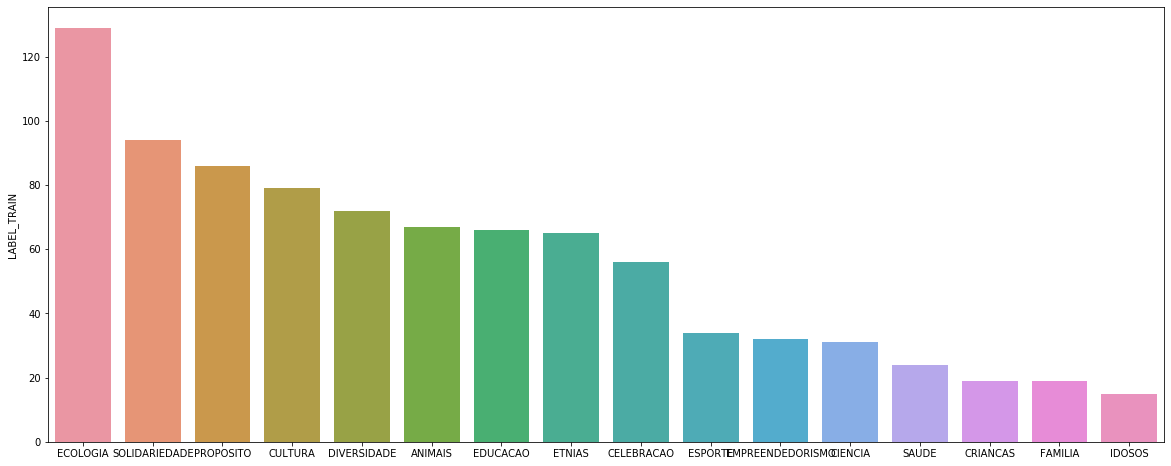

In [11]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print(
    "Mean number of samples for the target variable is: ",
    average_samples_per_label)
print(
    "Standard deviation number of samples for the target variable is: ",
    standard_deviation_for_labels)

''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with
    they're too afar from the other labels frequencies average. Let's use
    standard deviation to check it'''
def is_it_further_than_std_deviations( value ):
    is_too_much = value > average_samples_per_label + standard_deviation_for_labels
    is_too_little = value < average_samples_per_label - standard_deviation_for_labels
    if is_too_much or is_too_little:
        message = "Warning"
    else:
        message = "Okay"

    return message

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]

    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

Let's oversample the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.
And also undersample the most common labels by ramdonly select less samples.


Let's check the labels found: 
Underpresented labels:  ['CRIANCAS', 'FAMILIA', 'IDOSOS']
Overrepresented labels:  ['ECOLOGIA', 'SOLIDARIEDADE']
Unchanged Labels:  ['CELEBRACAO', 'DIVERSIDADE', 'CULTURA', 'ANIMAIS', 'EMPREENDEDORISMO', 'EDUCACAO', 'PROPOSITO', 'ETNIAS', 'ESPORTE', 'SAUDE', 'CIENCIA']
ECOLOGIA            88
SOLIDARIEDADE       88
PROPOSITO           86
CULTURA             79
DIVERSIDADE         72
ANIMAIS             67
EDUCACAO            66
ETNIAS              65
CELEBRACAO          56
SCARCE_GROUP        53
ESPORTE             34
EMPREENDEDORISMO    32
CIENCIA             31
SAUDE               24
Name: LABEL_TRAIN, dtype: int64


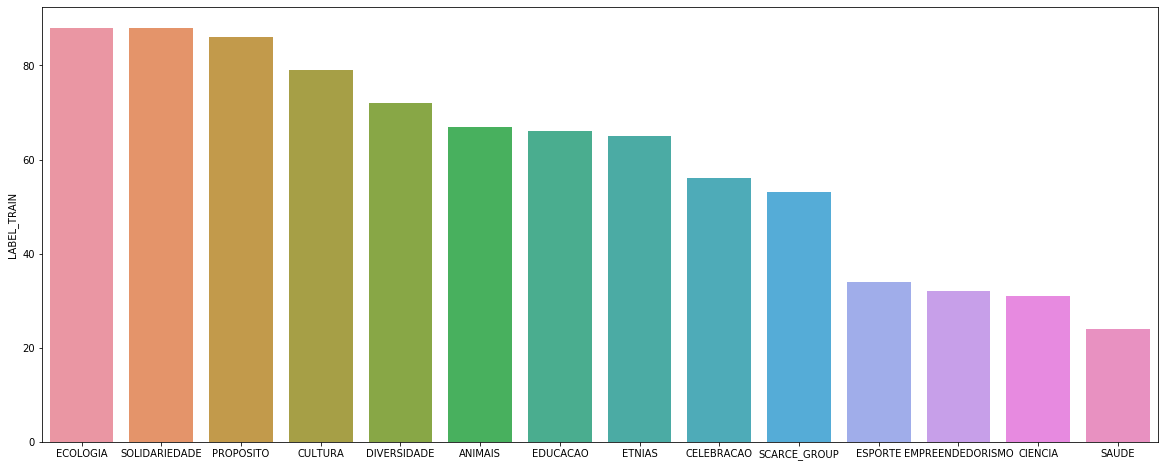

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 11 to 1191
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    888 non-null    object
 1   TEXT_VARIABLE  888 non-null    object
dtypes: object(2)
memory usage: 20.8+ KB
None


In [12]:
''' Let's create another dataframe and find which samples will be and how they'll be part of it'''
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = []
over_represented_labels = []
max_number_of_samples = average_samples_per_label + standard_deviation_for_labels
min_number_of_samples = average_samples_per_label - standard_deviation_for_labels
for label in tqdm(data_labels):
    if data_labels_count[label] < min_number_of_samples:
        under_represented_labels.append(label)
    elif data_labels_count[label] > max_number_of_samples:
        over_represented_labels.append(label)

unchanged_labels = list(set(data_labels) - set(under_represented_labels) - set(over_represented_labels))

print("Let's check the labels found: ")
print("Underpresented labels: ", under_represented_labels)
print("Overrepresented labels: ", over_represented_labels)
print("Unchanged Labels: ", unchanged_labels)

df_preprocessed_grouped = pd.DataFrame(columns=df_preprocessed_data.columns)

for label in unchanged_labels:
    unchanged_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(unchanged_rows)

''' Now we have found which ones are under represented we'll add them to the new
    DataFrame and then change the under represented label to SCARCE_GROUP '''
for label in under_represented_labels:
    under_represented_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(under_represented_rows)

GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_preprocessed_grouped = df_preprocessed_grouped.replace(
    {TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)

""" For the over represented, we'll select some of the samples."""
for label in over_represented_labels:
    over_represented_rows = df_preprocessed_data[
        df_preprocessed_data[TARGET_VARIABLE] == label].sample(int(max_number_of_samples))
    df_preprocessed_grouped = df_preprocessed_grouped.append(over_represented_rows)

print(df_preprocessed_grouped[TARGET_VARIABLE].value_counts())

"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()
print(df_preprocessed_data.info())

### Storing partial progress

In [13]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [14]:
"""  Let"s store the  data """
df_preprocessed_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [15]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
print(df_data.head())

   LABEL_TRAIN                                      TEXT_VARIABLE
57  CELEBRACAO  Vai,Brasil! Nos dias 23 a 30 de julho, acontec...
69  CELEBRACAO  Um aluno brasileiro de 18 anos ganho um prêmio...
78  CELEBRACAO  O brasileiro Luiz Gabriel Tiago é um dos indic...
89  CELEBRACAO  Planejando uma viagem ao exterior? O primeiro ...
91  CELEBRACAO  Um ex-usuário de drogas, que perdeu a própria ...


## Text Filter(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the text variable.

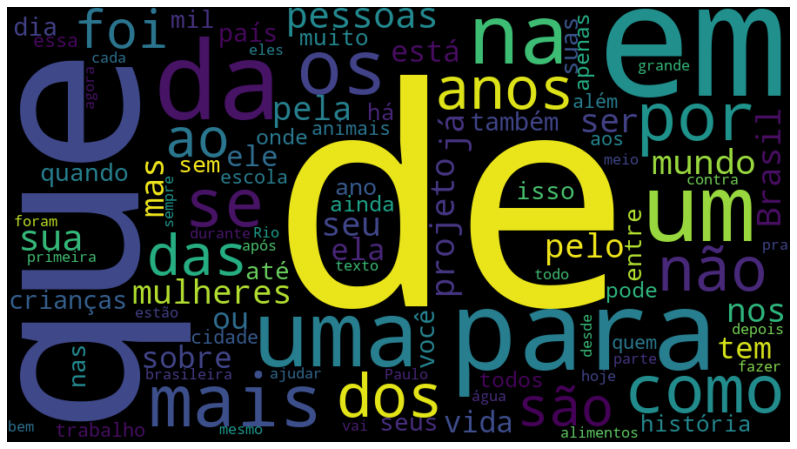

,       5017
de      4424
.       3048
a       2476
e       2437
o       1886
que     1867
do      1371
em      1332
para    1267
da      1265
um       888
com      853
uma      851
no       759
é        747
na       679
mais     544
os       521
por      440
A        439
as       426
se       411
-        409
como     407
dtype: int64


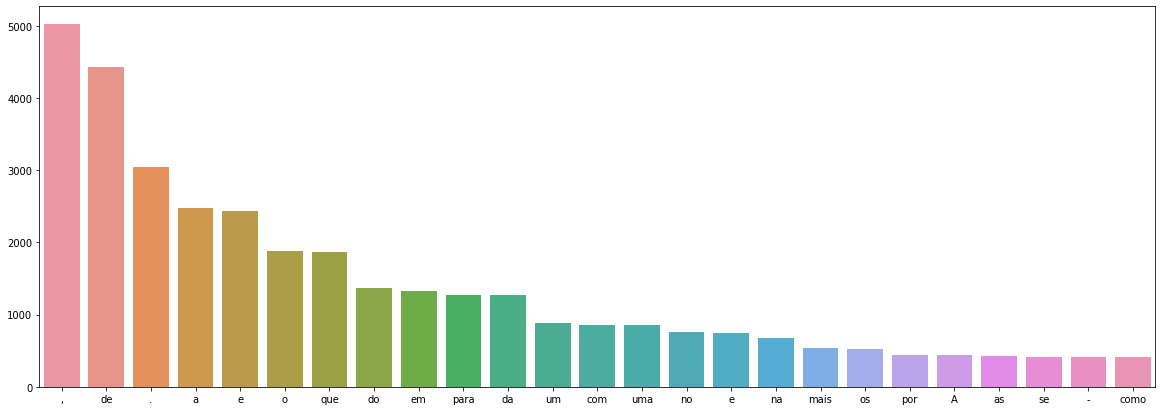

In [16]:
text_variable = 'TEXT_VARIABLE'
raw_text_column = df_data[text_variable]
generate_wordcloud(raw_text_column)
print(generate_freq_dist_plot(raw_text_column))

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [17]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese'))).union(set(['anos', 'ano', 'dia', 'dias']))
stopword_pattern = r'\b(?:{})\b'.format(r'|'.join(stopwords_set))
symbols_pattern = r'(?:[{}]|[^\w\s])'.format(punctuation)
space_pattern = r'\s\s+'
number_pattern = r'\d'
print("This is the stopword pattern: ", stopword_pattern)
print("This is the number pattern:", number_pattern)
print("This is the symbols pattern: ", symbols_pattern)
print("This is the space pattern:", space_pattern)

This is the stopword pattern:  \b(?:caminho|pela|estivéramos|direita|aqui|nível|sexta|não|estive|vós|te|estará|está|bem|houveríamos|fazemos|fez|fazeis|lhe|através|apoio|primeiro|vossas|nada|esta|ambos|podem|estiver|dele|nossos|quer|teria|devem|aquele|fora|pegar|fazia|naquela|estivestes|cedo|houveremos|dessa|estar|logo|iniciar|seriam|sempre|houver|que|é|sétimo|isto|dia|boa|delas|isso|hei|forma|estão|só|embora|estivéssemos|dezasseis|estejam|estiverem|conselho|vão|possivelmente|usar|sou|meses|este|sua|baixo|nuns|hajam|estavam|da|houverão|tenha|tentar|teríamos|sistema|certamente|as|tens|desse|quanto|obrigado|estejamos|número|favor|último|momento|menos|nas|vários|eventual|máximo|primeira|oitava|minhas|faço|valor|toda|geral|tivéssemos|estivessem|aqueles|maioria|todos|demais|dão|houvessem|dizem|nenhuma|vocês|próxima|puderam|põem|oitavo|irá|vos|inicio|zero|ainda|nossa|pontos|treze|terá|éramos|inclusive|porém|quero|grande|esteja|anos|vosso|vai|ela|grandes|ali|tente|saber|antes|onze|cima|estiver

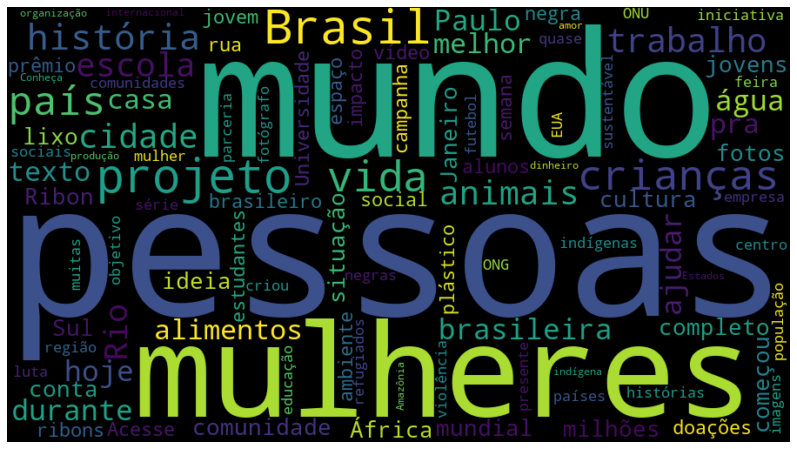

pessoas       241
mundo         203
Brasil        182
mulheres      168
projeto       146
vida          145
crianças      136
país          125
história       99
animais        89
trabalho       88
cidade         87
Rio            82
ajudar         81
água           76
Paulo          74
texto          70
escola         68
completo       66
alimentos      65
pra            65
África         64
melhor         64
ideia          63
brasileira     63
dtype: int64


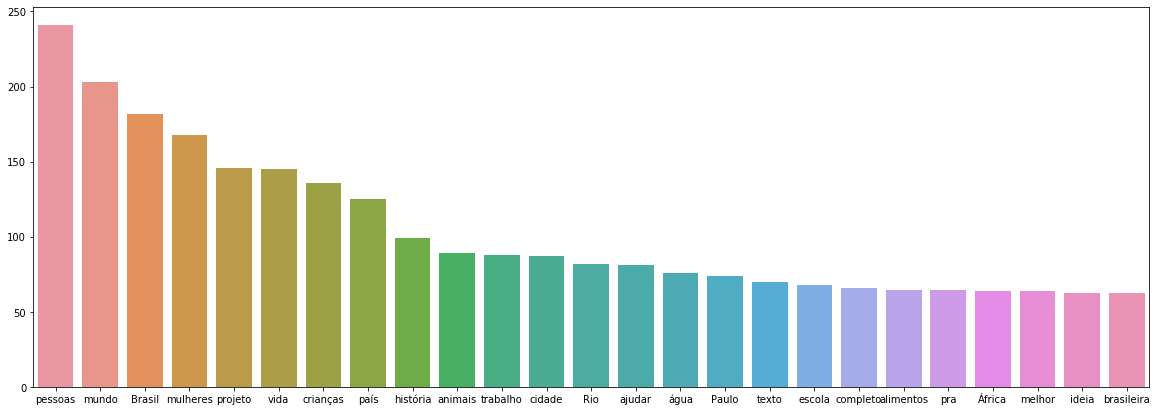

In [18]:
''' Processing text on caracteres level'''
df_data['PREPROCESSED_TEXT'] = df_data[text_variable]
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    number_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    stopword_pattern, " ", case=False)
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    symbols_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    space_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.strip()
generate_wordcloud(df_data['PREPROCESSED_TEXT'])
print(generate_freq_dist_plot(df_data['PREPROCESSED_TEXT']))

### Results
Now the most common words are way more expressive.

### Lemmatizing and stemming


Pipe already present.
['tagger', 'sentencizer', 'parser', 'ner']



Documents without lemmatization
pessoas       241
mundo         203
Brasil        182
mulheres      168
projeto       146
vida          145
crianças      136
país          125
história       99
animais        89
trabalho       88
cidade         87
Rio            82
ajudar         81
água           76
Paulo          74
texto          70
escola         68
completo       66
pra            65
alimentos      65
África         64
melhor         64
brasileira     63
ideia          63
dtype: int64


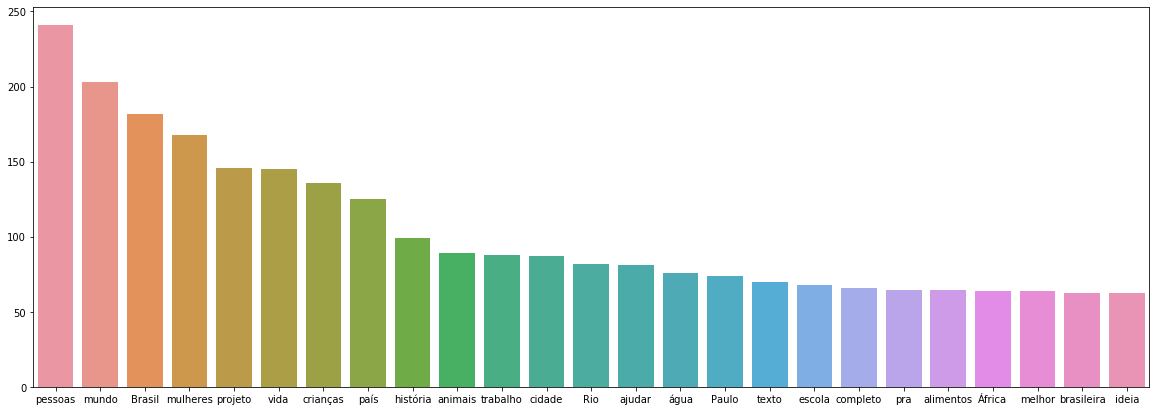

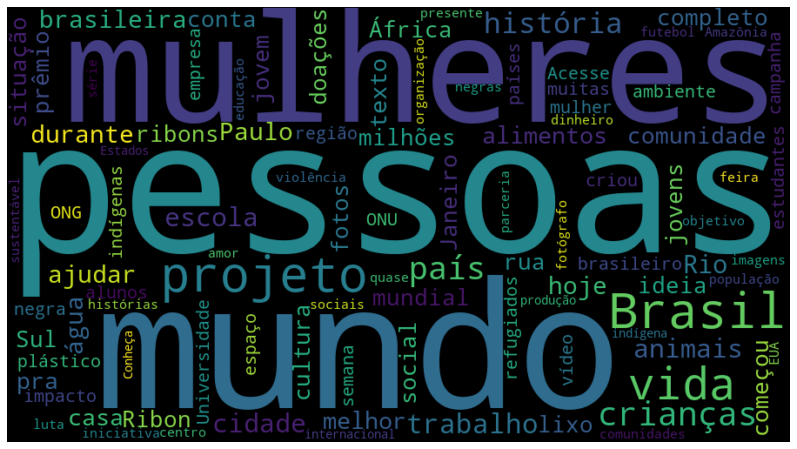

Documents with minor lemmatization
pessoas       246
mundo         217
mulheres      198
projeto       183
brasil        182
vida          149
crianças      140
país          130
história      104
trabalho       94
animais        90
escola         89
cidade         89
rio            86
brasileira     83
ajudar         81
hoje           80
água           78
durante        76
paulo          74
alimentos      71
pra            70
texto          70
casa           69
melhor         69
dtype: int64


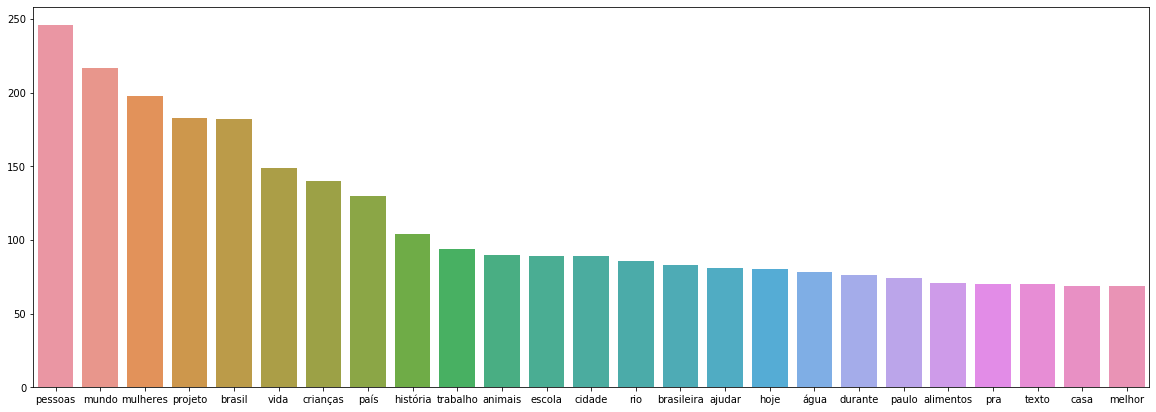

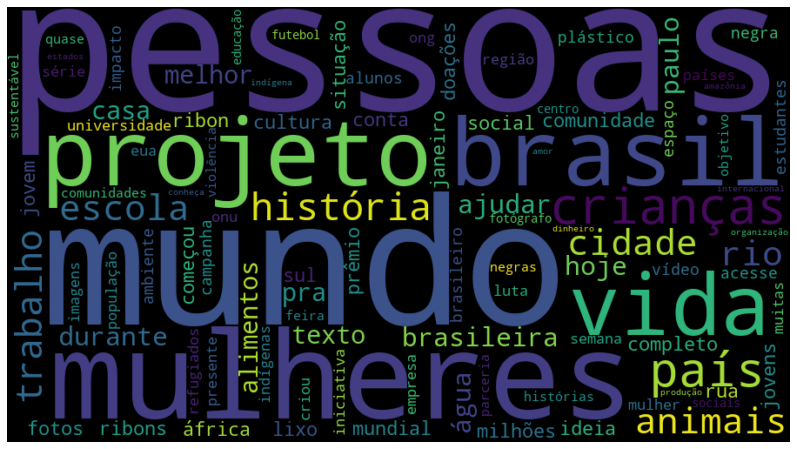

Documents with full lemmatization
pessoa        259
mulher        205
mundo         203
criar         187
Brasil        182
ajudar        171
vidar         169
país          165
passar        157
trabalhar     152
brasileiro    152
criança       151
projeto       146
história      135
casar         115
negro         111
cidade        111
contar        106
fazer          99
comunidade     98
escola         94
começar        93
animar         93
chegar         90
viver          90
dtype: int64


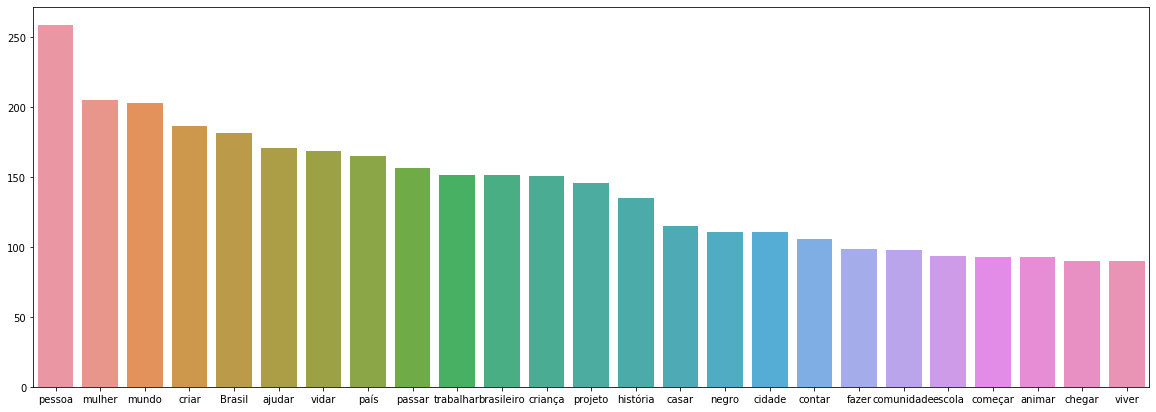

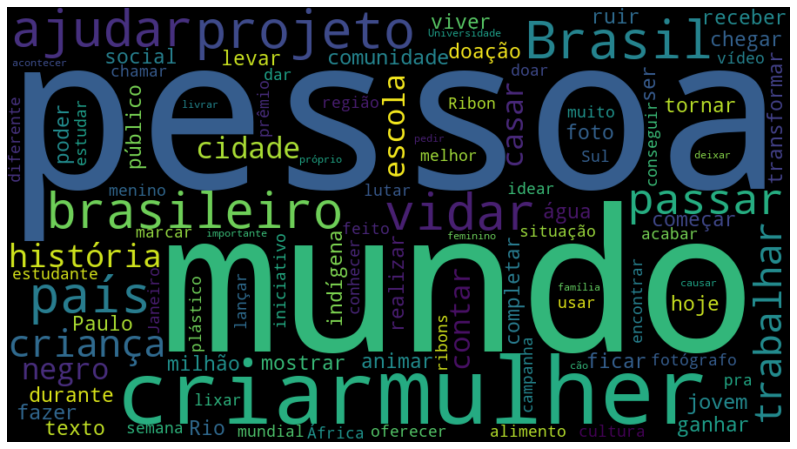

In [141]:
preprocessed_text_data = df_data['PREPROCESSED_TEXT'].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
normalized_doc = []
raw_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    tokenized_data.append(doc)
    raw_doc.append(
        " ".join(
            [word.text for word in doc]))
    lemmatized_doc.append(
        " ".join(
            [word.lemma_ for word in doc]))
    normalized_doc.append(
        " ".join(
            [word.norm_ for word in doc]))
    
df_data['RAW_DOC'] = raw_doc
df_data['NORMALIZED_DOC'] = normalized_doc
df_data['LEMMATIZED_DOC'] = lemmatized_doc

print("Documents without lemmatization")
print(generate_freq_dist_plot(df_data['RAW_DOC']))
generate_wordcloud(df_data['RAW_DOC'])
print("Documents with minor lemmatization")
print(generate_freq_dist_plot(df_data['NORMALIZED_DOC']))
generate_wordcloud(df_data['NORMALIZED_DOC'])
print("Documents with full lemmatization")
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))
generate_wordcloud(df_data['LEMMATIZED_DOC'])



### Entity Recognition
Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model(spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at the named persons or families

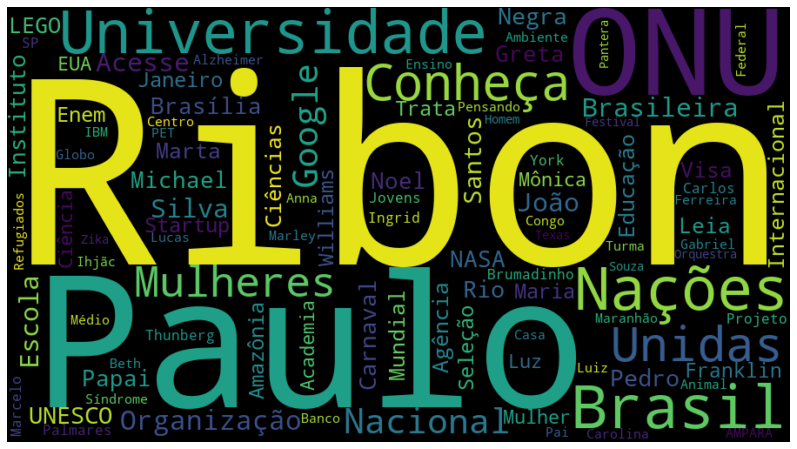

Ribon           47
Paulo           46
ONU             36
Brasil          19
Universidade    19
Nações          19
Conheça         18
Unidas          17
Nacional        15
Google          15
Mulheres        14
João            14
Silva           14
Acesse          14
Escola          13
Santos          12
Organização     12
Brasileira      12
Pedro           11
Rio             11
Noel            10
Papai           10
Greta           10
Negra           10
Michael         10
dtype: int64


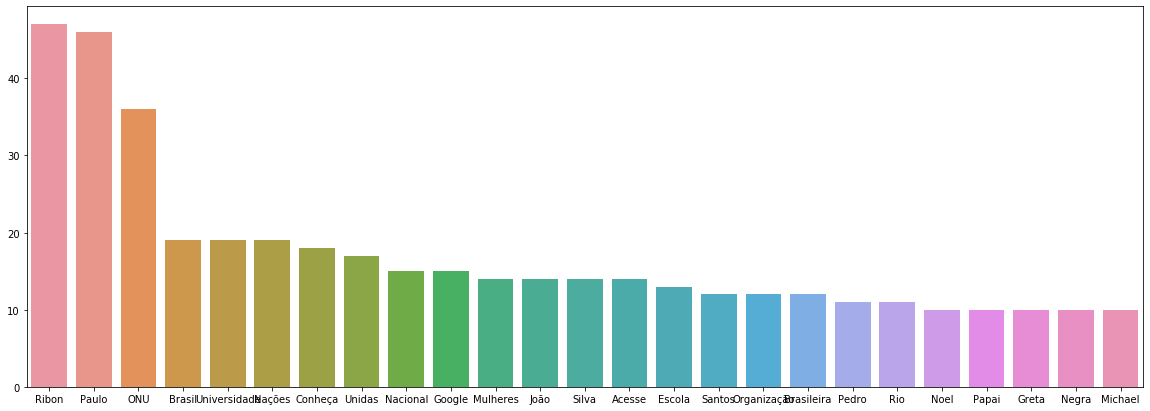

In [90]:
''' First we take a look at the found entities'''
entities_lists = []
entity_unwanted_types = set(['PER', 'ORG'])

for docs in tokenized_data:
    entities_text = ""
    for entity in docs.ents:
        if entity.label_ in entity_unwanted_types:
            entities_text += " " + entity.text
    entities_text = entities_text.strip()
    entities_lists.append(entities_text)
            
df_data['ENTITIES'] = entities_lists
generate_wordcloud(df_data['ENTITIES'])
print(generate_freq_dist_plot(df_data['ENTITIES']))

### Removing Entities

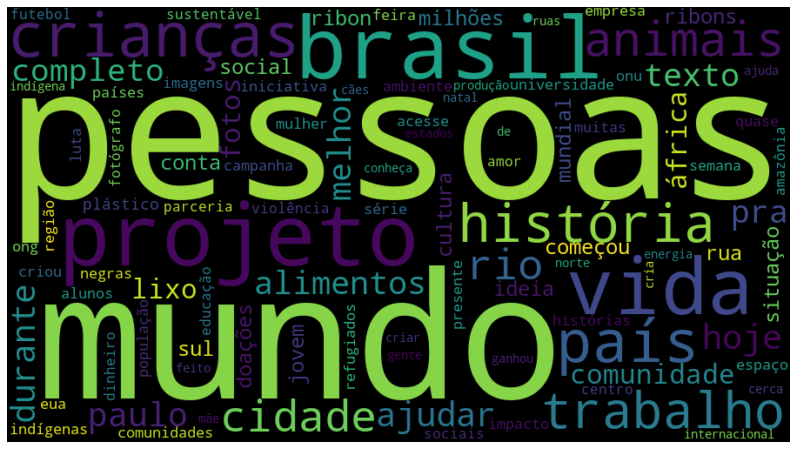

pessoas       246
mundo         217
projeto       183
brasil        182
vida          149
crianças      140
país          130
história      104
trabalho       94
animais        90
cidade         89
rio            86
ajudar         81
hoje           80
durante        76
paulo          74
alimentos      71
texto          70
pra            70
melhor         69
completo       66
comunidade     65
lixo           65
fotos          64
áfrica         64
dtype: int64


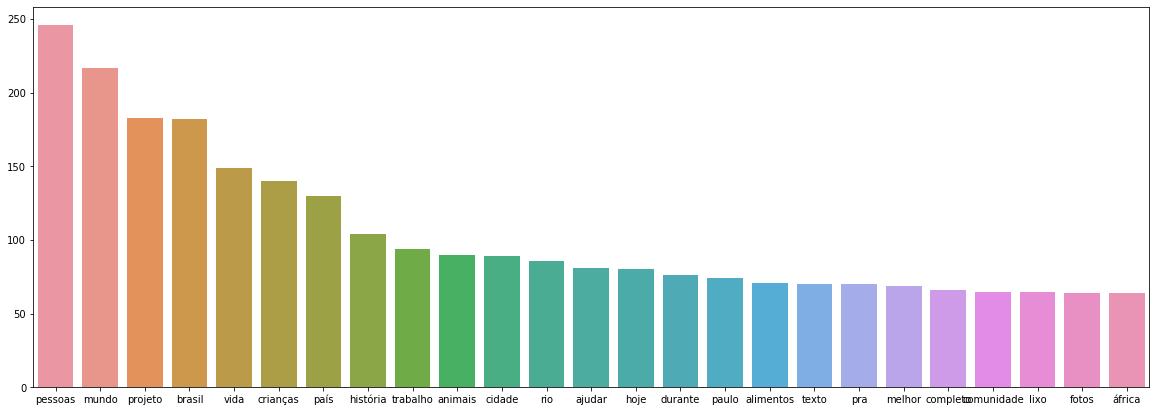

In [142]:
entities_set = set()
entities_set = set([ word for word_list in list(map(list, df_data['ENTITIES'].str.split(" ")))
                            for word in word_list ])
entities_set.remove("")
entities_pattern = r'\b(?:{})\b'.format('|'.join(entities_set)) 

''' Processing text on entity level'''
df_data['PROCESSED_DOC'] = df_data['NORMALIZED_DOC'].str.replace(entities_pattern, " ")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### POS Analysis
Let's take a look in the parts of speech presents in the dataset

PROPN    13948
NOUN     10144
VERB      9517
ADJ       6766
ADV        870
DET        519
AUX        308
ADP        306
PRON        80
SYM         69
X           51
NUM         35
CCONJ       22
SCONJ       10
PUNCT        8
SPACE        8
PART         2
dtype: int64


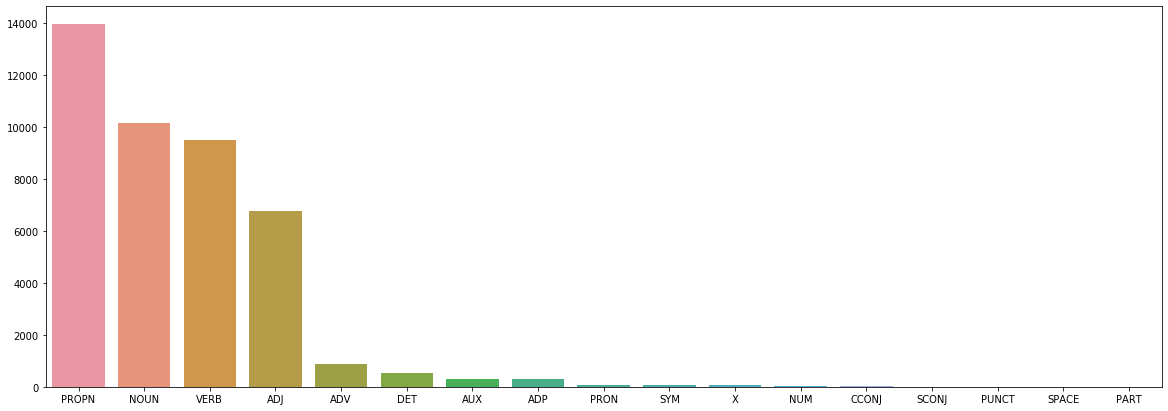

In [143]:
semantics_data = []
for doc in tokenized_data:
    semantics_data.append(" ".join([word.pos_ for word in doc]))

df_data['SEMANTICS'] = semantics_data
print(generate_freq_dist_plot(df_data['SEMANTICS']))

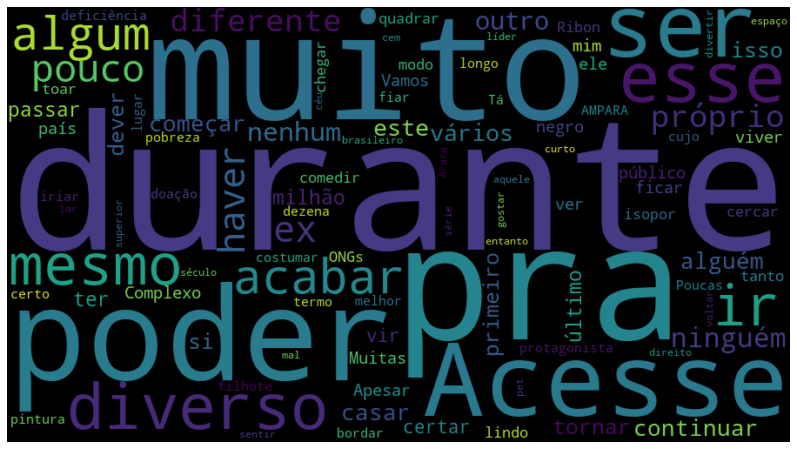

pra          65
muito        59
durante      57
poder        45
Acesse       43
d            41
ser          31
esse         29
diverso      28
o            26
n            23
mesmo        23
ir           22
acabar       21
algum        20
Durante      19
pouco        18
haver        16
º            15
próprio      15
diferente    15
D            15
ex           12
R            12
outro        12
dtype: int64


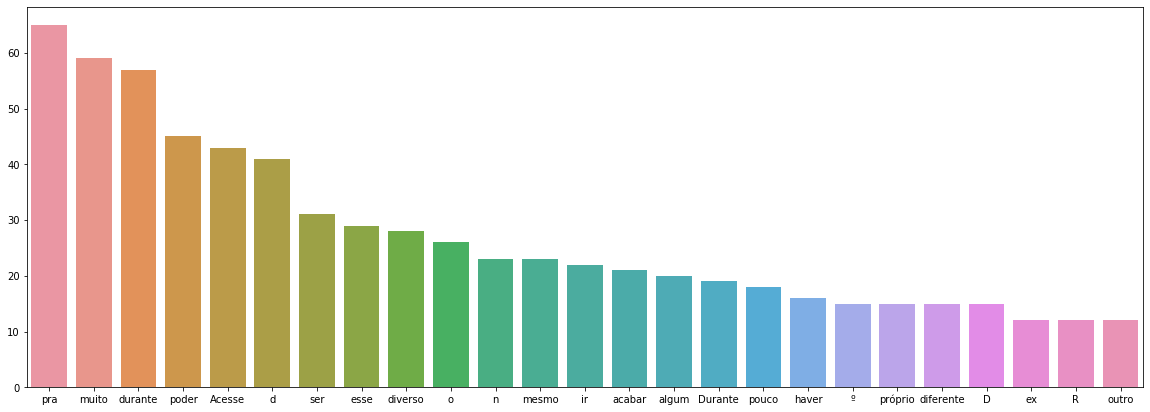

In [93]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

unwanted_pos_text = []
for doc in tokenized_data:
    unwanted_pos_text.append(
        " ".join(
            [word.lemma_ if not str(word.pos_) in ALLOWED_POS else "" for word in doc]))
    
df_data['UNWANTED_POS'] = unwanted_pos_text
generate_wordcloud(df_data['UNWANTED_POS'])
print(generate_freq_dist_plot(df_data['UNWANTED_POS']))

### Removing POS

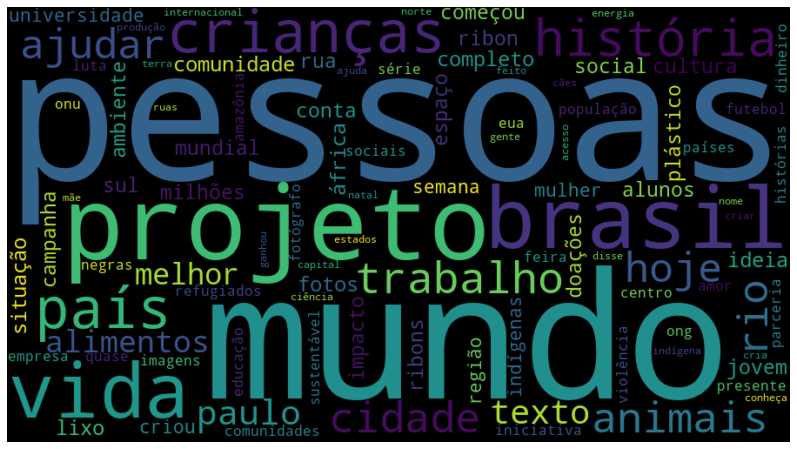

pessoas       246
mundo         217
projeto       183
brasil        182
vida          149
crianças      140
país          130
história      104
trabalho       94
cidade         89
animais        89
rio            85
ajudar         81
hoje           80
paulo          74
alimentos      70
texto          70
completo       66
melhor         66
comunidade     65
lixo           65
fotos          64
áfrica         64
ideia          63
situação       62
dtype: int64


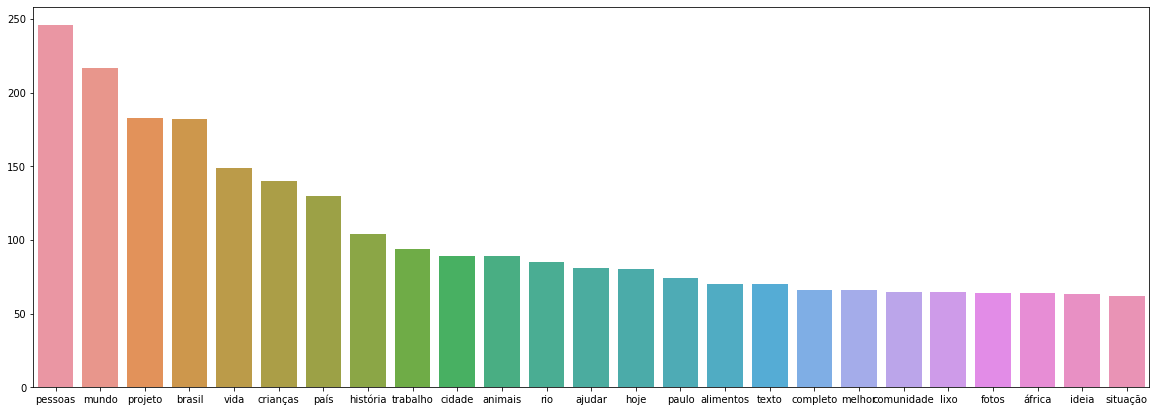

In [144]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
for doc in tokenized_data:
    processed_doc.append(
        " ".join(
            [word.norm_ if str(word.pos_) in ALLOWED_POS else "" for word in doc]))

df_data['PROCESSED_DOC'] = processed_doc
''' Processing text on entity level again '''
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(entities_pattern, " ")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

In [137]:
normalized_set = set()
lemmatized_set = set()

for docs in tokenized_data:
    for word in docs:
        normalized_set.add(word.norm_)
        lemmatized_set.add(word.lemma_)
    
print(sorted(list(normalized_set.intersection(lemmatized_set))))
    

['abacaxi', 'abandonar', 'abastecer', 'abastecido', 'abastecimento', 'aberto', 'abertura', 'abolir', 'abolição', 'abordar', 'abrangente', 'abraçar', 'abrigar', 'abrigo', 'abril', 'abrir', 'abruptamente', 'absolutamente', 'absoluto', 'absorvente', 'abstinência', 'abstratas', 'abundante', 'abundância', 'abóbora', 'acabar', 'acadêmico', 'acadêmicos', 'acalmar', 'acampamento', 'acarajé', 'acaso', 'aceitar', 'aceitação', 'acelerador', 'acelerar', 'acender', 'acertar', 'aceso', 'acessando', 'acessar', 'acesse', 'acessibilidade', 'acesso', 'acessível', 'achar', 'acidentalmente', 'acidente', 'acima', 'acirramento', 'acolher', 'acolhido', 'acolhimento', 'acomodar', 'acompanhar', 'aconchegante', 'acontecer', 'acordar', 'acostamento', 'acreditar', 'action', 'acumular', 'acúmulo', 'adaptar', 'adaptação', 'aderir', 'administração', 'admiração', 'admitir', 'adolescente', 'adolescência', 'adota', 'adotada', 'adotadas', 'adotado', 'adotados', 'adotamos', 'adotar', 'adotaram', 'adoção', 'adulto', 'adve

In [145]:
""" Removing extra spaces originated from processing """
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(space_pattern, " ").str.strip()
df_data['UNWANTED_POS'] = df_data['UNWANTED_POS'].str.replace(space_pattern, " ").str.strip()

### Viewing the most common words for each label

Label:  CELEBRACAO
mundo            16
trabalho         15
brasil           15
ciência          13
nobel            12
país             11
internacional    11
bióloga          10
greta            10
vida             10
projeto          10
pessoas          10
onu               9
paz               8
sul               8
universidade      7
ficou             7
recebe            7
jovem             7
leite             7
música            7
história          7
ganhou            6
sexual            6
notícias          6
dtype: int64


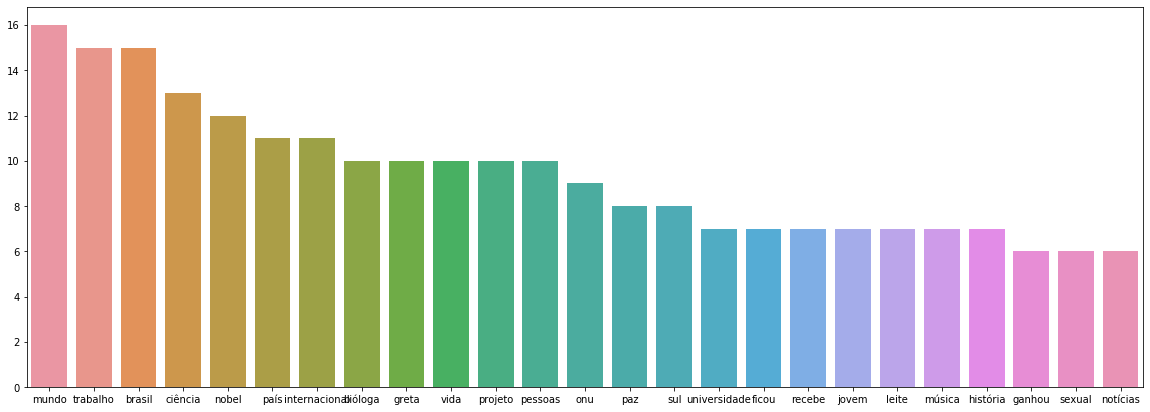

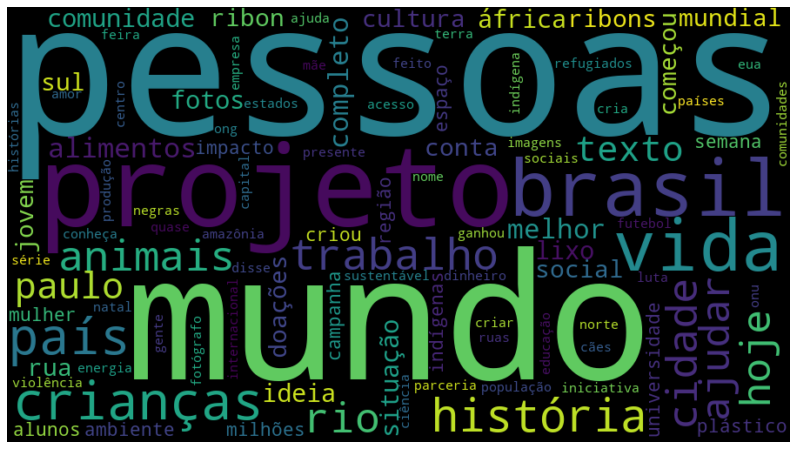

Label:  DIVERSIDADE
pessoas            27
crianças           17
braille            17
brasil             15
mundo              15
projeto            13
luta               12
nome               10
diversidade        10
lei                10
social              9
inclusão            9
pele                9
igualdade           9
visuais             9
hoje                9
lego                9
sociais             8
desenvolvimento     8
direitos            8
empresa             8
gênero              8
país                7
deficientes         7
joão                7
dtype: int64


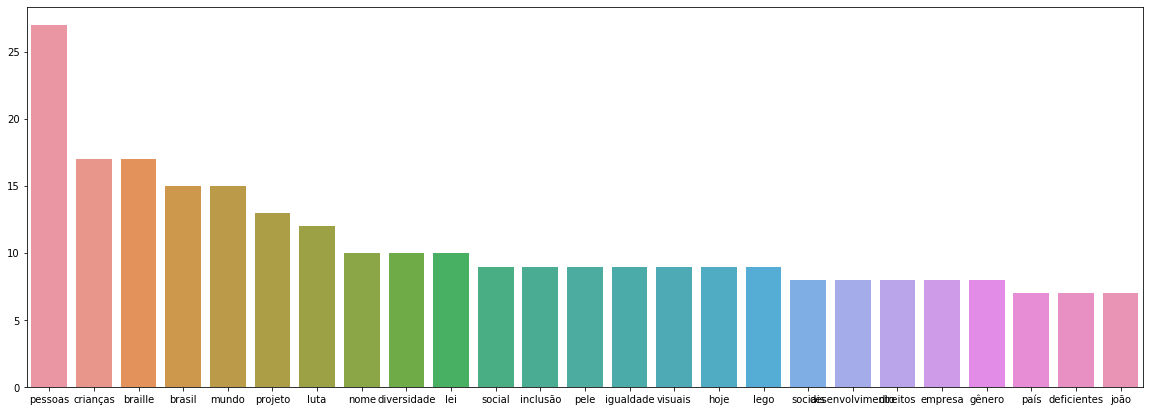

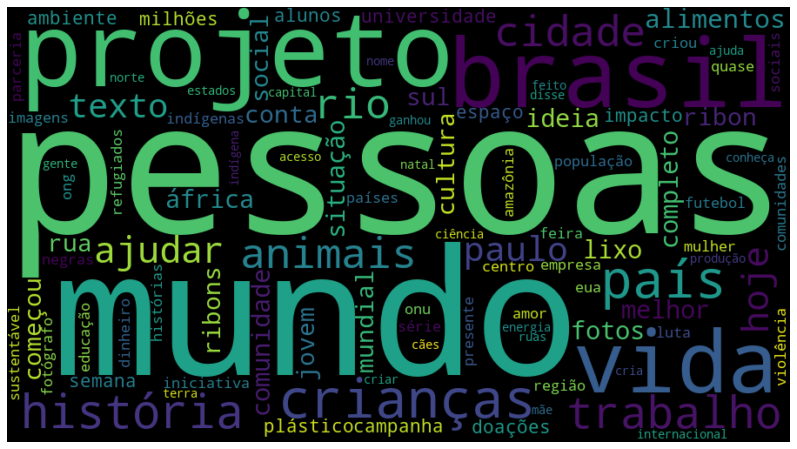

Label:  CULTURA
brasil         42
rio            25
mundo          24
história       23
cultura        21
cultural       18
pessoas        17
texto          15
vida           15
fotos          15
carnaval       14
completo       14
fotógrafo      13
patrimônio     13
paulo          12
negros         12
resistência    12
hoje           11
povos          10
negras         10
terra          10
livro          10
indígenas      10
afro           10
cidade          9
dtype: int64


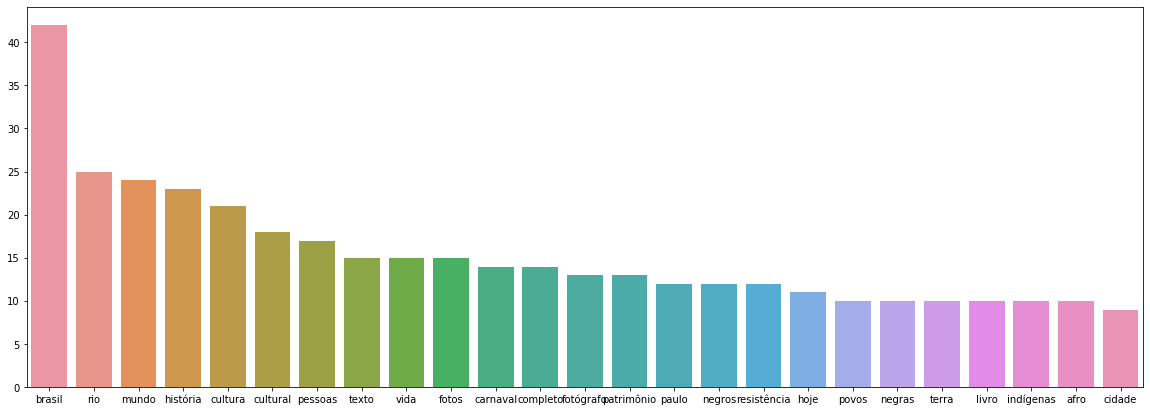

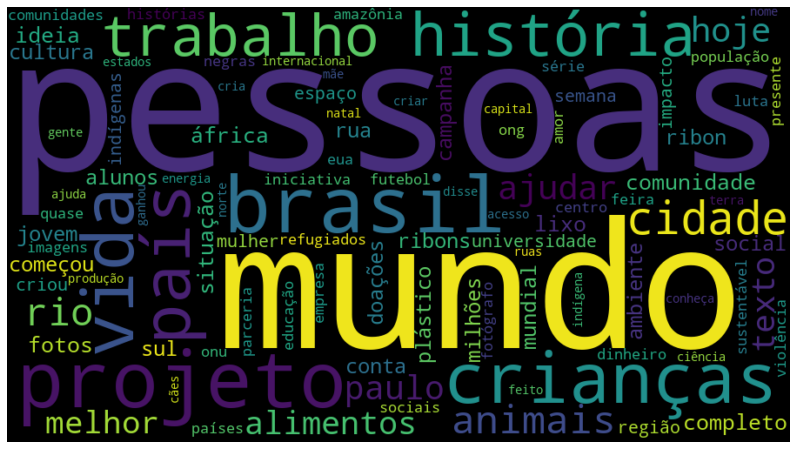

Label:  ANIMAIS
animais        69
cães           36
vida           22
animal         21
elefantes      18
cachorros      14
extinção       13
pessoas        13
gatos          12
rua            12
ong            11
amor           10
espécie        10
mundo          10
abandonados    10
espécies       10
situação        9
cão             9
país            9
ambiente        8
quênia          8
texto           8
vira            8
cidade          8
tartarugas      8
dtype: int64


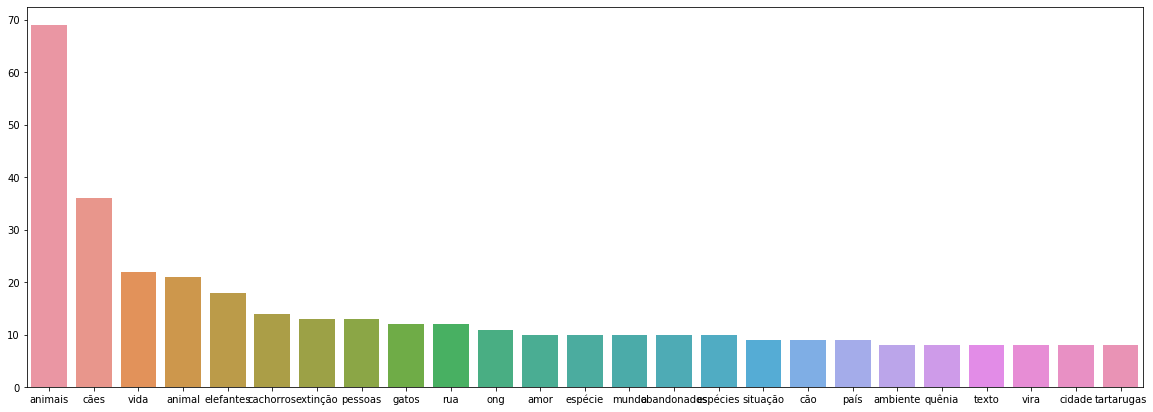

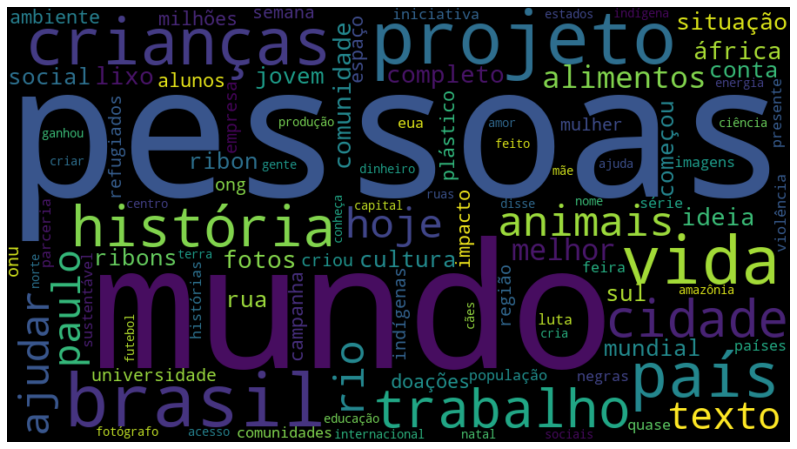

Label:  EMPREENDEDORISMO
projeto        26
pessoas        18
alimentos      15
mundo          15
violência      13
brasil         12
trabalho       10
comunidades     9
situação        9
algodão         9
produção        8
projetos        8
vida            8
iniciativa      8
sp              7
negras          7
comunidade      7
social          7
onu             7
paulo           7
país            7
dinheiro        6
cidade          6
milhões         6
ideia           6
dtype: int64


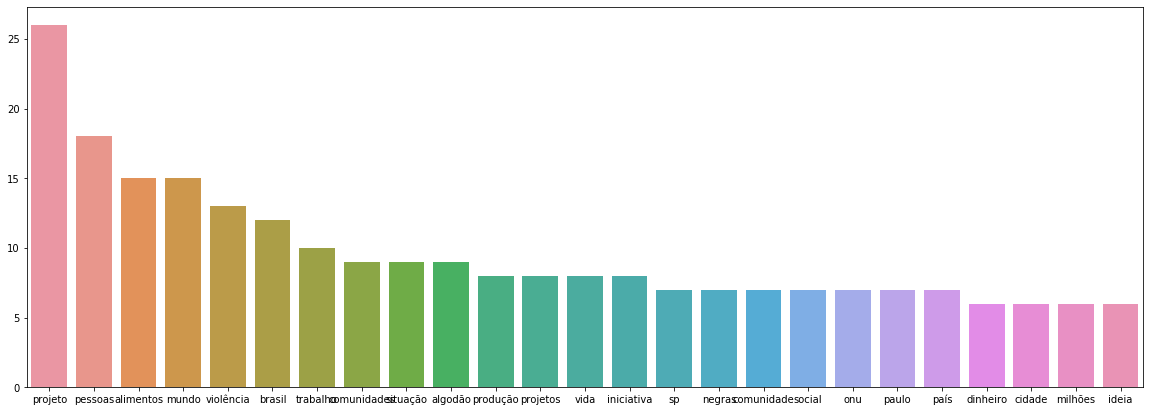

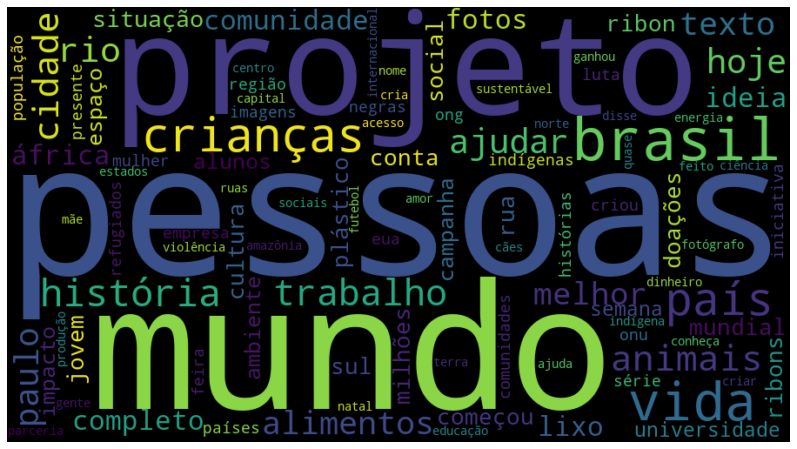

Label:  EDUCACAO
crianças        35
projeto         28
alunos          27
educação        20
brasil          17
escolas         17
mundo           16
rio             14
ensino          12
trabalho        12
enem            12
pessoas         12
melhor          12
país            11
universidade    11
cidade          11
livros          11
música          11
aulas           10
professor       10
centro           9
nacional         9
pública          9
vida             9
professora       8
dtype: int64


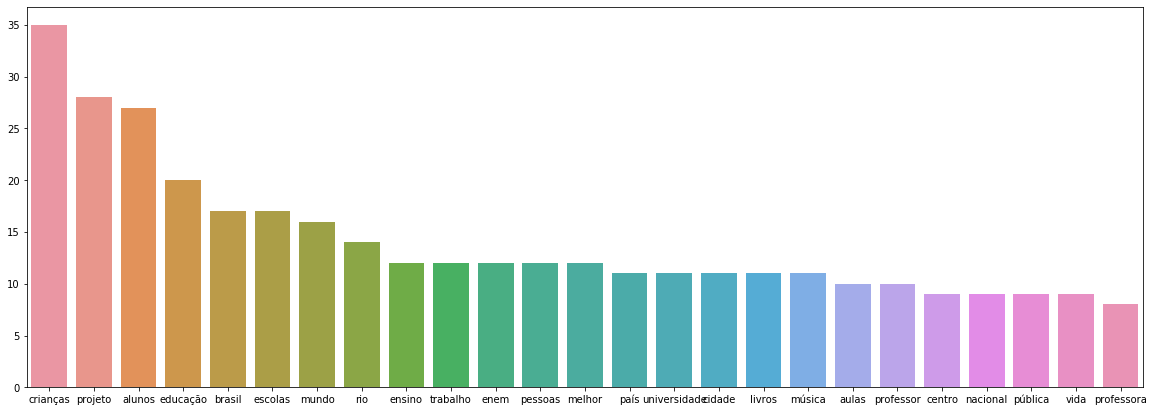

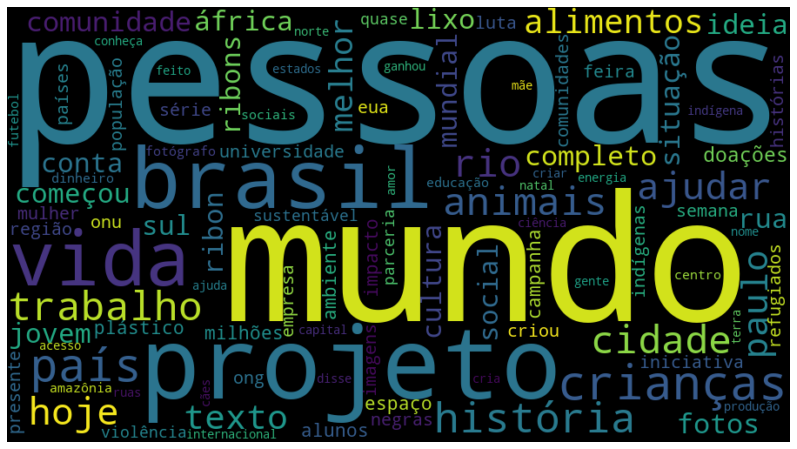

Label:  PROPOSITO
ribons        46
ribon         42
doações       35
pessoas       25
mundo         23
impacto       20
presente      19
visa          16
completo      16
comunidade    16
ajudar        16
texto         15
doados        15
boas          14
projeto       13
doadores      12
hoje          11
doação        11
crianças      11
milhões       11
usuários      10
juntos        10
causas        10
abaixo        10
ajude         10
dtype: int64


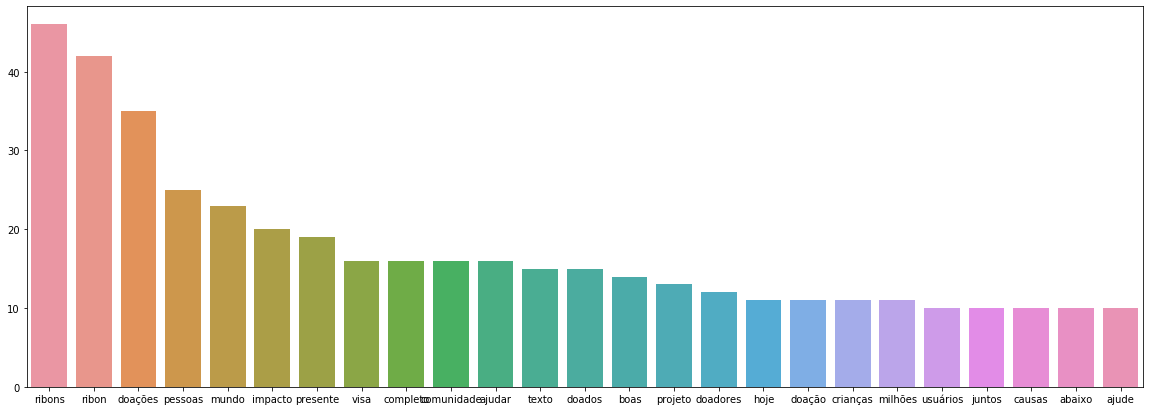

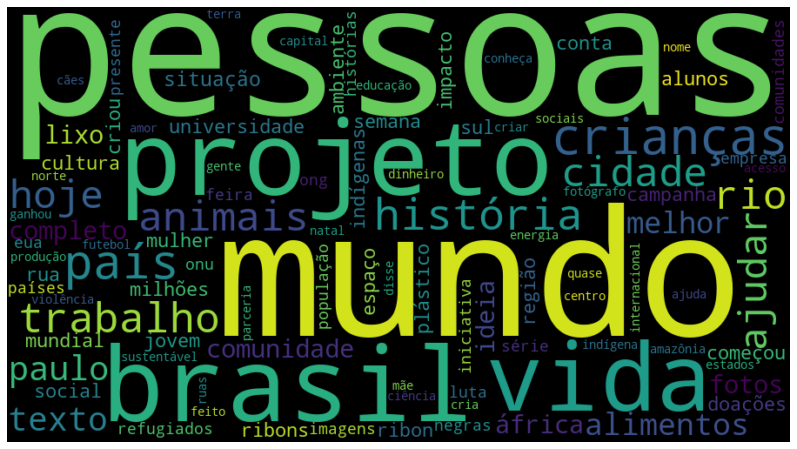

Label:  ETNIAS
indígenas     29
país          29
áfrica        23
mundo         22
fotos         22
brasil        20
cultura       17
indígena      16
história      16
fotógrafo     15
série         15
pessoas       15
povos         14
vida          14
continente    14
hoje          14
imagens       13
texto         12
região        11
completo      11
guerra        10
congo         10
projeto        9
floresta       9
jeito          9
dtype: int64


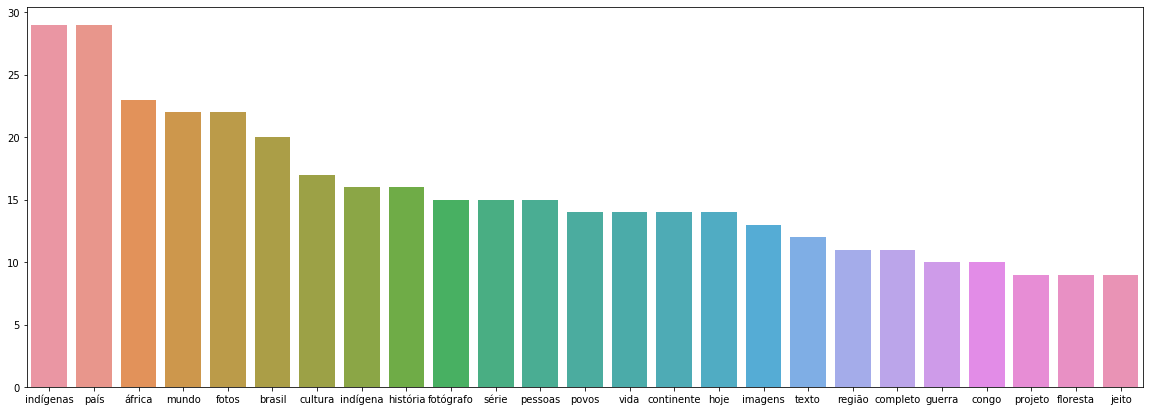

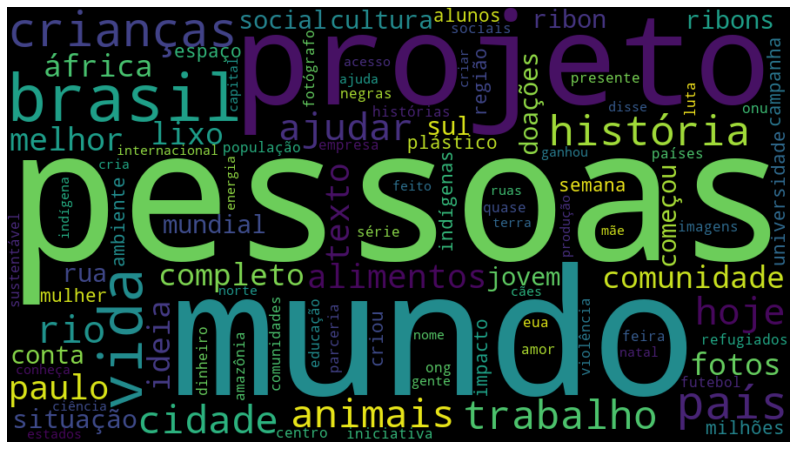

Label:  ESPORTE
futebol         27
seleção         20
mundo           19
copa            18
mundial         14
brasil          13
história        12
projeto         10
jogos           10
feminina        10
histórias       10
feminino        10
atletas          9
pessoas          8
país             8
atleta           7
marta            7
gols             7
campeonato       7
camisa           6
jogadora         6
masculino        6
conta            6
melhor           6
participação     6
dtype: int64


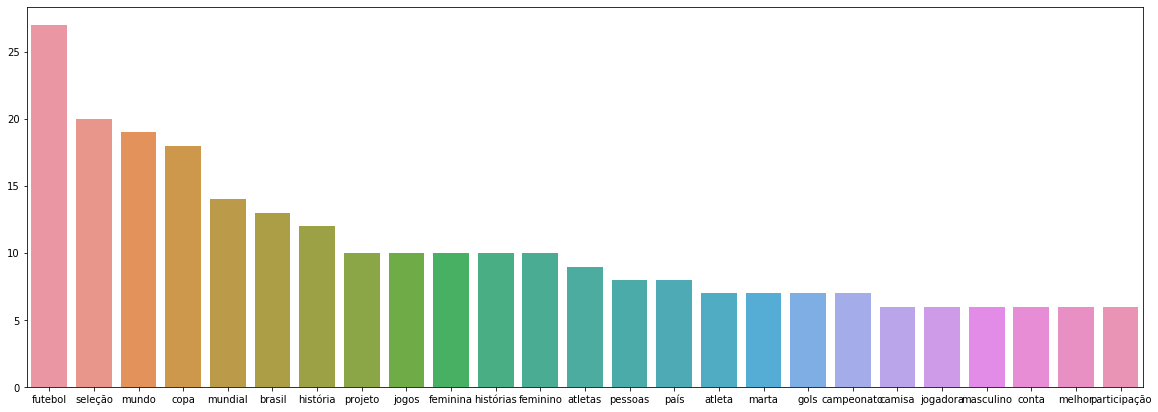

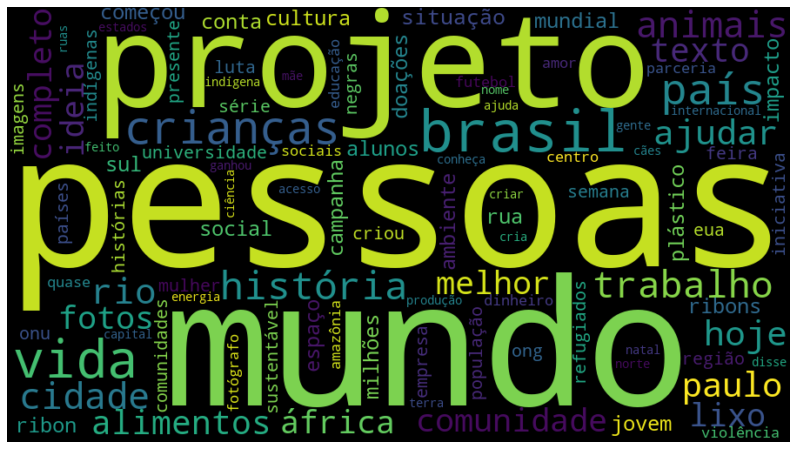

Label:  SAUDE
pessoas      15
saúde         8
morte         8
vida          7
médico        6
natureza      6
pacientes     6
mundo         6
ajudar        5
libras        5
escrever      5
crianças      5
brasil        5
projeto       5
corpo         4
pesquisa      4
mental        4
doenças       4
pesquisas     4
contato       4
ouvido        4
diversão      4
melhor        4
ajuda         4
acesso        4
dtype: int64


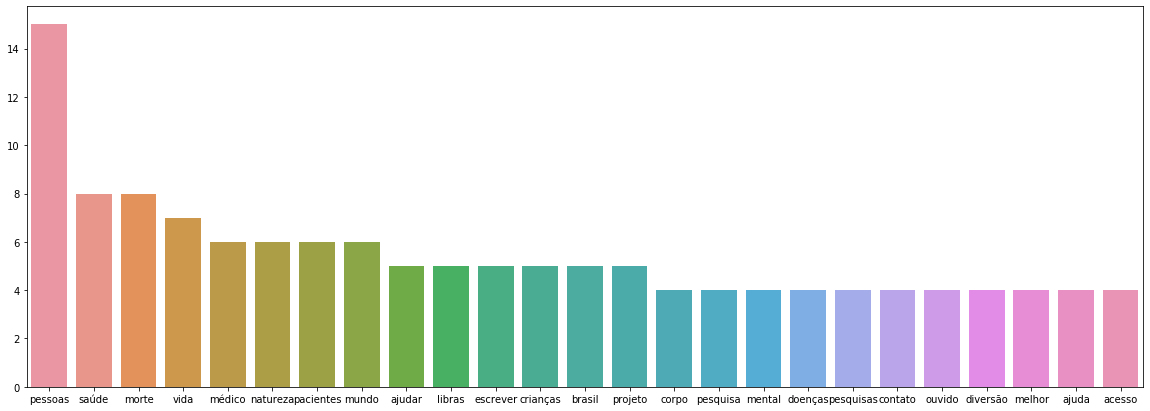

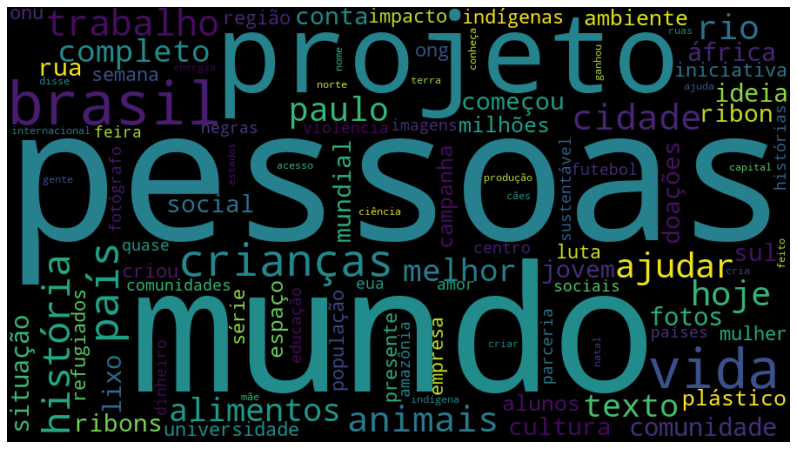

Label:  CIENCIA
nasa            14
espaço          11
jovem           10
espacial        10
tecnologia       9
criou            9
sinais           8
cientistas       7
ciência          7
pessoas          7
ideia            6
estados          6
lixo             6
garrafa          6
unidos           6
christina        5
imagens          5
transformar      5
mundo            5
lua              5
astronautas      5
missão           5
plástico         5
universidade     5
consumo          5
dtype: int64


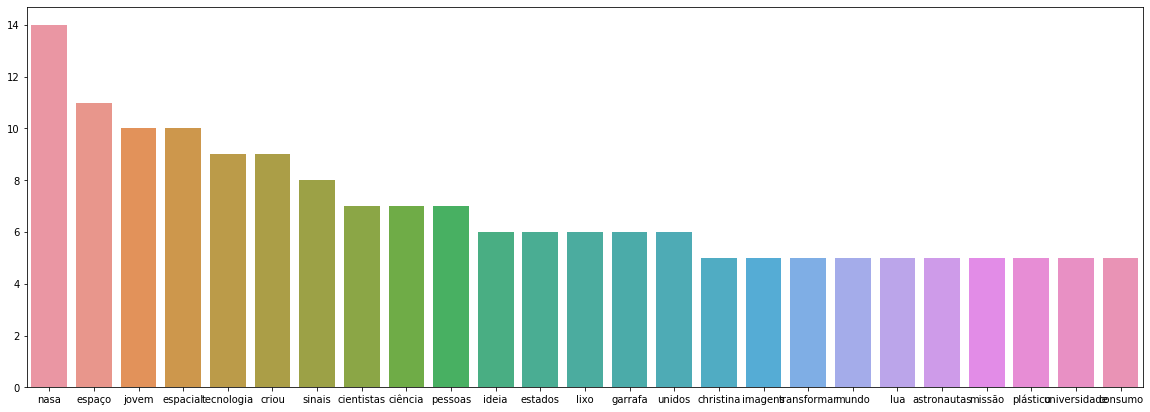

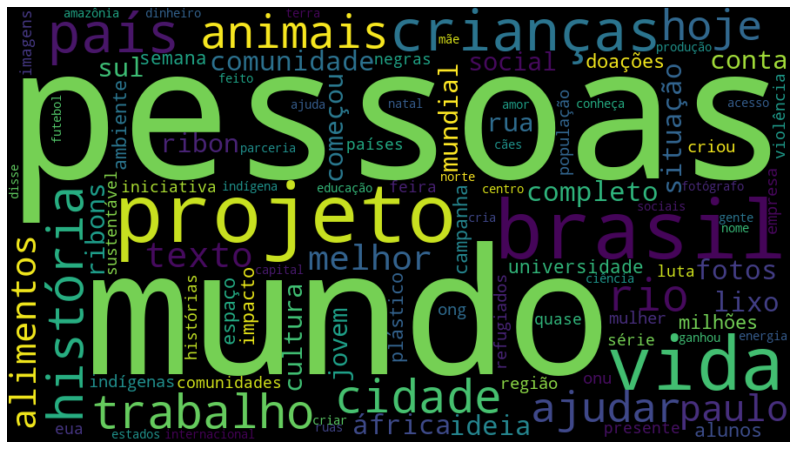

Label:  SCARCE_GROUP
crianças    22
mãe         19
vida        13
amor        12
mundo       11
história    11
filha       10
pessoas     10
cidade       9
pai          9
idosos       8
natal        8
filhos       8
filho        8
começou      7
criança      6
paulo        6
hoje         6
fotos        6
câncer       6
senhora      5
momentos     5
cabelo       5
bebês        5
músicas      5
dtype: int64


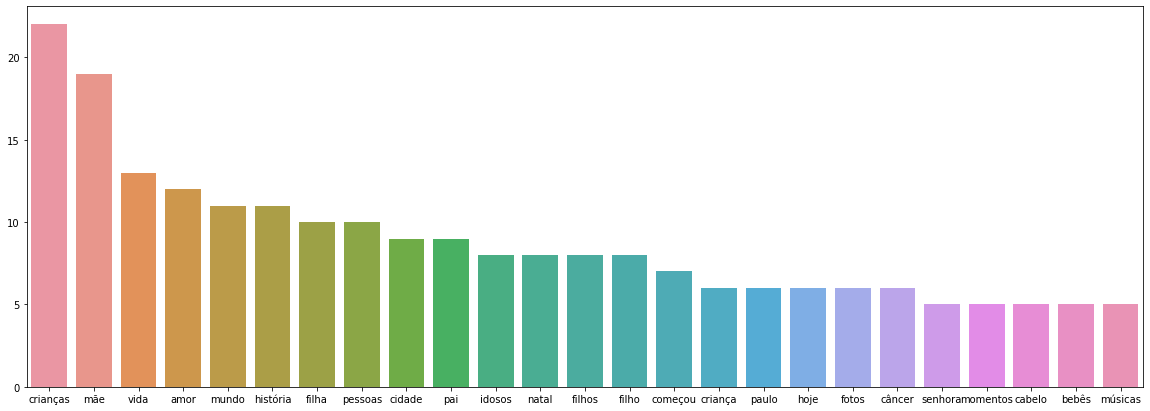

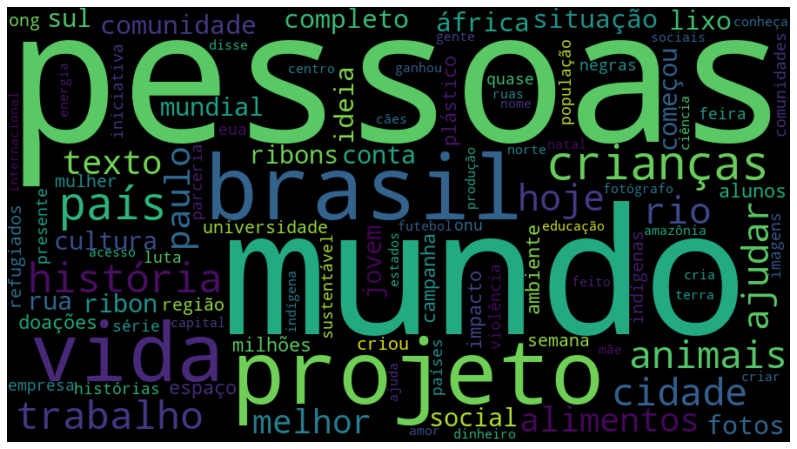

Label:  ECOLOGIA
lixo           40
plástico       40
energia        22
projeto        22
mundo          20
árvores        20
sustentável    18
pessoas        18
brasil         18
amazônia       17
ambiente       16
solar          16
cidade         13
embalagens     13
empresa        12
feita          12
ideia          12
resíduos       12
vida           12
país           11
milhões        11
materiais      11
ambiental      11
população      11
mundial        10
dtype: int64


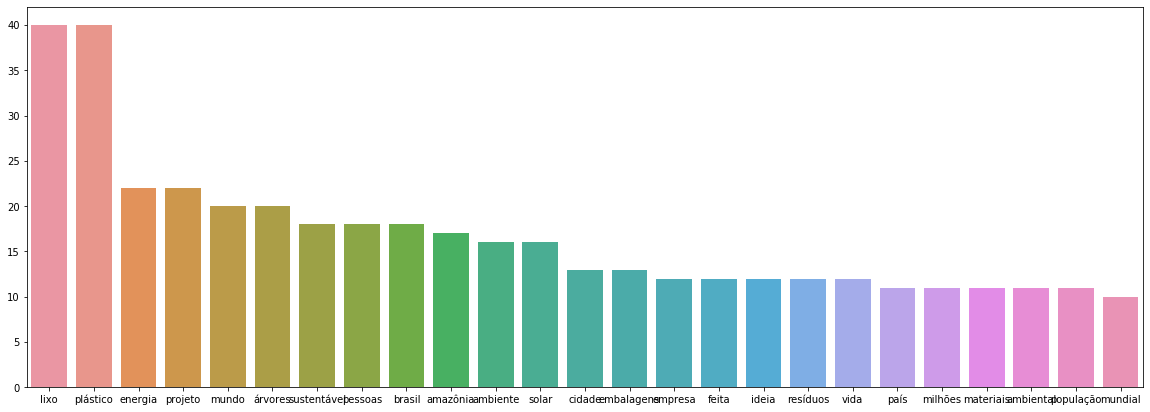

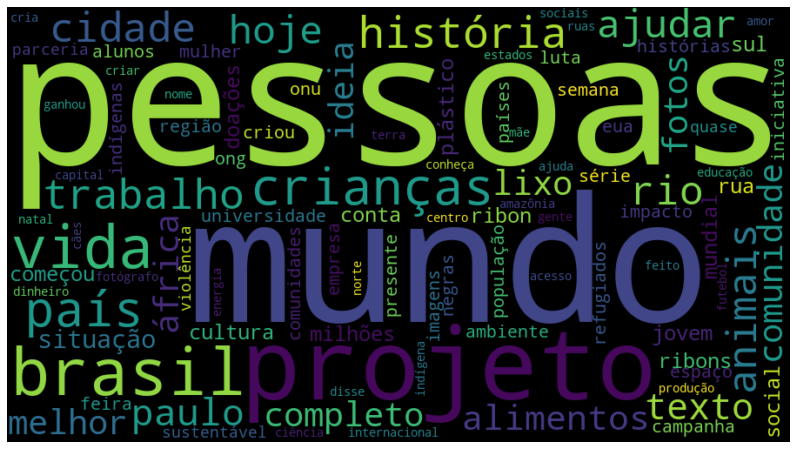

Label:  SOLIDARIEDADE
pessoas       51
alimentos     24
ajudar        24
projeto       24
crianças      23
vida          20
refugiados    19
rua           18
situação      17
mundo         15
rio           14
comprar       13
comida        12
país          12
brasil        12
ajuda         11
moradores     11
brumadinho    11
homem         11
eua           10
cidade        10
campanha      10
semana         9
começou        9
ruas           8
dtype: int64


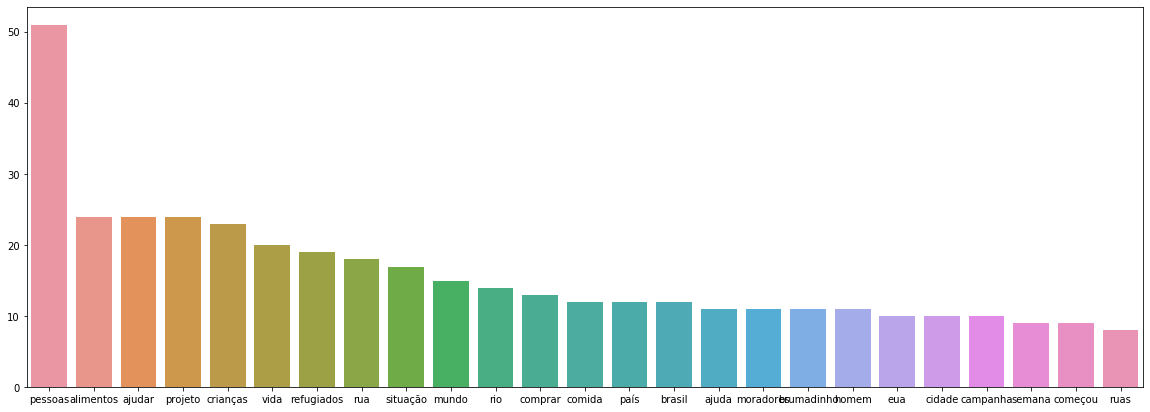

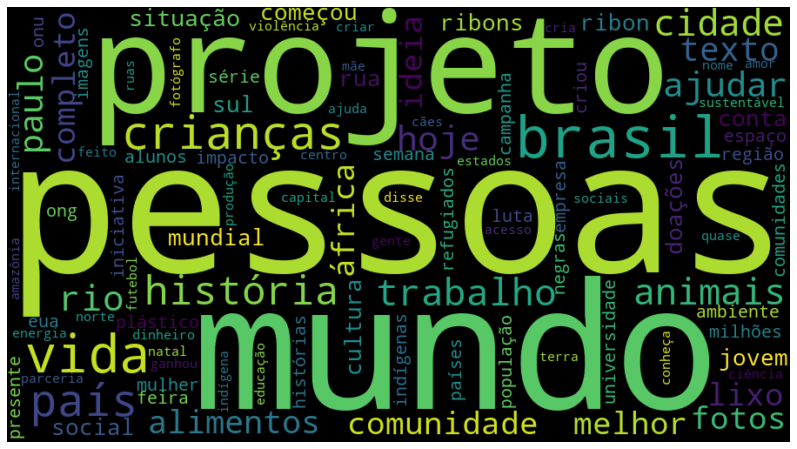

In [146]:
target_labels = df_data[TARGET_VARIABLE].unique()

for label in target_labels:
    words_for_label = df_data[df_data[TARGET_VARIABLE] == label]
    print("Label: ", label)
    print(generate_freq_dist_plot(words_for_label['PROCESSED_DOC']))
    generate_wordcloud(df_data['PROCESSED_DOC'])

### Storing partial progress

In [147]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_processed_data.xlsx"

In [148]:
df_data.to_excel(excel_filename)

 ## Text Parser(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [149]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 57 to 152
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL_TRAIN        841 non-null    object
 1   TEXT_VARIABLE      841 non-null    object
 2   PREPROCESSED_TEXT  841 non-null    object
 3   LEMMATIZED_DOC     841 non-null    object
 4   ENTITIES           703 non-null    object
 5   PROCESSED_DOC      841 non-null    object
 6   SEMANTICS          841 non-null    object
 7   UNWANTED_POS       594 non-null    object
 8   NORMALIZED_DOC     841 non-null    object
 9   RAW_DOC            841 non-null    object
dtypes: object(10)
memory usage: 72.3+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [150]:
missing_variables = ['ENTITIES', 'UNWANTED_POS']
df_processed_data = df_processed_data.drop(columns=missing_variables).dropna()
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 57 to 152
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL_TRAIN        841 non-null    object
 1   TEXT_VARIABLE      841 non-null    object
 2   PREPROCESSED_TEXT  841 non-null    object
 3   LEMMATIZED_DOC     841 non-null    object
 4   PROCESSED_DOC      841 non-null    object
 5   SEMANTICS          841 non-null    object
 6   NORMALIZED_DOC     841 non-null    object
 7   RAW_DOC            841 non-null    object
dtypes: object(8)
memory usage: 59.1+ KB
None


### Choosing best parameters for Counting and Vectorizing

In [151]:
is_gridsearching = False
if is_gridsearching:
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score

    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0001),
        'vect__max_df': np.arange(0.2, 0.9, 0.1),
        'vect__max_features': [None, 1000, 10000, 20000],
        'vect__ngram_range': [(1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
        'tfidf__norm': ['l1', 'l2', None],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False, True],
        'tfidf__sublinear_tf' : [False, True]}

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    # Setting refit='AUC', refits an estimator on the whole dataset with the
    # parameter setting that has the best cross-validated AUC score.
    # That estimator is made available at ``gs.best_estimator_`` along with
    # parameters like ``gs.best_score_``, ``gs.best_params_`` and
    # ``gs.best_index_``
    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(df_data['PROCESSED_DOC'].values, df_data[TARGET_VARIABLE])
    results = gs.cv_results_
    print(results)

In [152]:
print(gs.best_params_)

{'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007, 'vect__ngram_range': (1, 2)}


In [153]:
print(results)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [154]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

print(count_vectors[0])
print(frequency_vectors[0])

  (0, 628)	1
  (0, 637)	1
  (0, 5479)	1
  (0, 5569)	1
  (0, 5994)	1
  (0, 5996)	1
  (0, 9310)	1
  (0, 9346)	1
  (0, 10946)	1
  (0, 10947)	1
  (0, 18431)	1
  (0, 18450)	1
  (0, 19988)	1
  (0, 19992)	1
  (0, 20550)	1
  (0, 20551)	1
  (0, 23798)	1
  (0, 23818)	1
  (0, 24672)	1
  (0, 24673)	1
  (0, 26534)	1
  (0, 26536)	1
  (0, 27297)	2
  (0, 27299)	1
  (0, 29497)	1
  (0, 29498)	1
  (0, 30924)	2
  (0, 30926)	1
  (0, 30927)	1
  (0, 32418)	1
  (0, 32474)	1
  (0, 32529)	1
  (0, 32548)	1
  (0, 32650)	1
  (0, 32656)	1
  (0, 38417)	1
  (0, 38422)	1
  (0, 38422)	0.030081398478515896
  (0, 38417)	0.023206960421939458
  (0, 32656)	0.030081398478515896
  (0, 32650)	0.02279985933269329
  (0, 32548)	0.030081398478515896
  (0, 32529)	0.01851442642091018
  (0, 32474)	0.02834952379838171
  (0, 32418)	0.013043137154532978
  (0, 30927)	0.030081398478515896
  (0, 30926)	0.030081398478515896
  (0, 30924)	0.04799991628944706
  (0, 29498)	0.030081398478515896
  (0, 29497)	0.02834952379838171
  (0, 27299)	0.030

In [155]:
''' Let's transform the lemmatized documents into count vectors '''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

mutual_info_vector = mutual_info_classif(count_vectors, df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.00271758 0.00271758 0.00293021 ... 0.0039433  0.00305272 0.00305272]


In [156]:
print(count_vectorizer.get_feature_names())

['aaah', 'aaah encontrado', 'aacd', 'aacd escolas', 'aba', 'aba comunidade', 'abacaxi', 'abacaxi cascas', 'abaeté', 'abaeté poesia', 'abaixo', 'abaixo ajudar', 'abaixo alunos', 'abaixo animais', 'abaixo assistir', 'abaixo contratada', 'abaixo doe', 'abaixo equador', 'abaixo escolher', 'abaixo exilado', 'abaixo fotografias', 'abaixo fotos', 'abaixo leia', 'abaixo ler', 'abaixo média', 'abaixo participar', 'abaixo passando', 'abaixo pessoas', 'abaixo policial', 'abaixo preencher', 'abaixo pureza', 'abaixo relatório', 'abaixo site', 'abaixo sonhou', 'abaixo sorte', 'abalado', 'abalado relações', 'abandona', 'abandona copo', 'abandonada', 'abandonada mãe', 'abandonada passou', 'abandonadas', 'abandonadas bibliotecas', 'abandonadas familiares', 'abandonadas itália', 'abandonadas museus', 'abandonado', 'abandonado agradece', 'abandonado incrível', 'abandonados', 'abandonados abrigos', 'abandonados criado', 'abandonados feridos', 'abandonados país', 'abandonados possuindo', 'abandonados sc', 

### Model Train and Cross-Validation

In [157]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

pipeline_simple = Pipeline([
    ('clf', clf)
])
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

scores = cross_val_score(
    pipeline,
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.506484593837535
Mean accuracy for implicit pipeline:  0.5148039215686275


### Evaluating the best model

In [158]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE],
    test_size=0.33, random_state=42)

pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.5
                  precision    recall  f1-score   support

      CELEBRACAO       0.65      0.68      0.67        22
     DIVERSIDADE       0.38      0.26      0.31        19
         CULTURA       1.00      0.25      0.40         8
         ANIMAIS       0.39      0.65      0.49        23
EMPREENDEDORISMO       0.62      0.30      0.40        27
        EDUCACAO       0.46      0.73      0.57        26
       PROPOSITO       0.36      0.29      0.32        28
          ETNIAS       0.00      0.00      0.00        10
         ESPORTE       0.57      0.67      0.62        12
           SAUDE       0.46      0.55      0.50        22
         CIENCIA       0.91      0.74      0.82        27
    SCARCE_GROUP       0.00      0.00      0.00         8
        ECOLOGIA       0.40      0.40      0.40        15
   SOLIDARIEDADE       0.45      0.68      0.54        31

        accuracy                           0.50       278
       macro avg       0.48      0.44      0.43       27

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Better visualising model classification

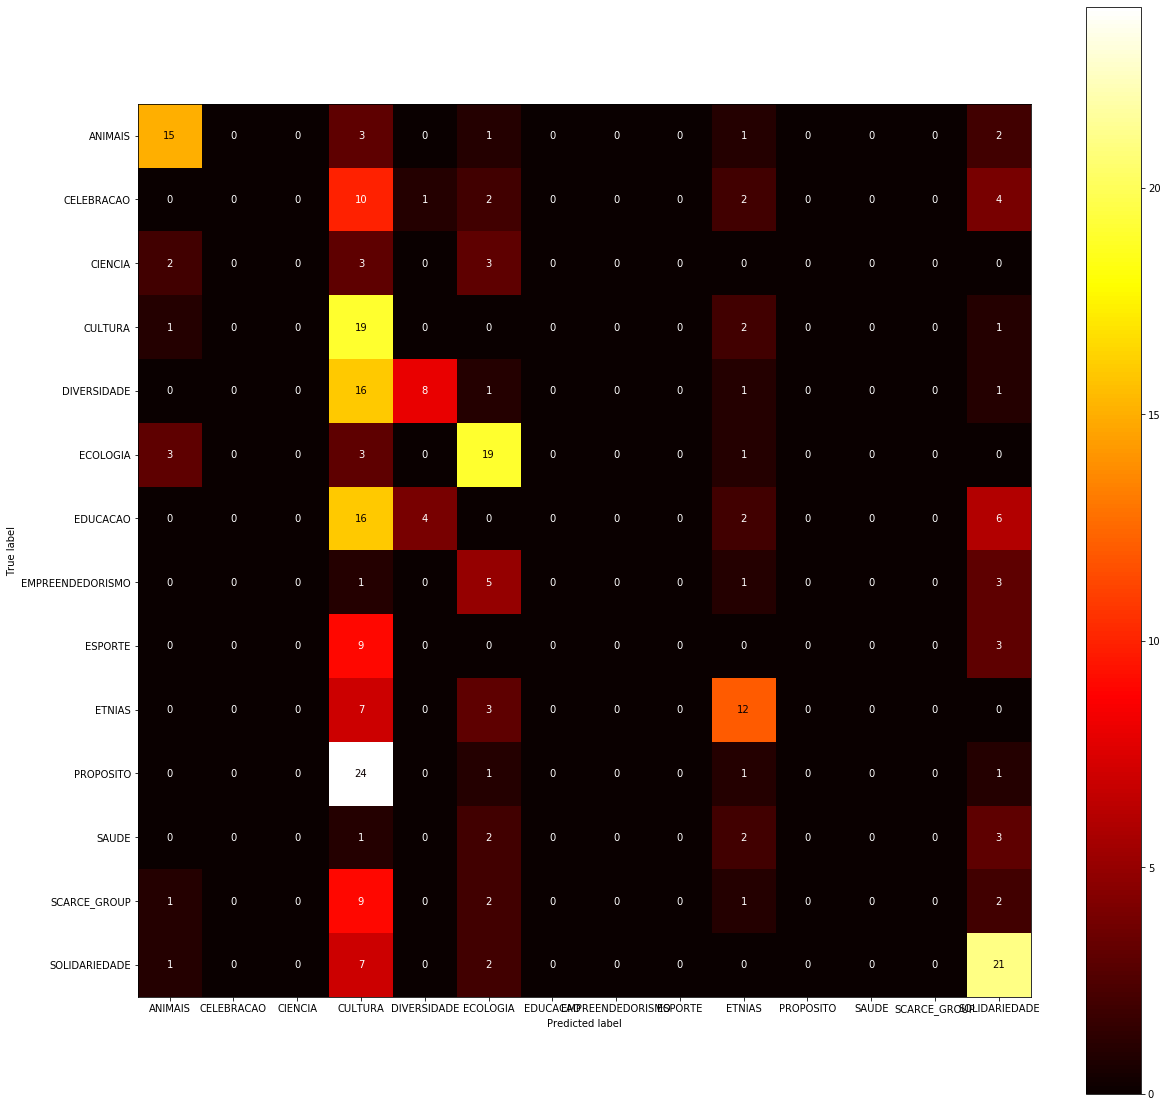

In [159]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

print(plot_confusion_matrix(pipeline, preds, labelsTest1, cmap='hot', ax=axes))

As we can see, we're having a terrible problem with the oversampled labels. Maybe undersampling them could improve the model perfomance